# ML project
>
> This final notebook aims to use the database, create our own csv file and fit a model to predict the grade of a movie from the features. 

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import plotly.express as px

In [2]:
connexion = sqlite3.connect('imdb.db')
c = connexion.cursor()

query = ("SELECT Film.grade , Film.length, Film.nb_vote, Film.language, Film.Country, Category.category, Actor.actor, Director.director FROM Film "
        " INNER JOIN Actor ON Actor.id == Casting.actor_id "
        " INNER JOIN Director ON Director.id == Casting.director_id "
        " INNER JOIN Category ON Film.category_id == Category.id"
        " INNER JOIN Casting ON Film.id == Casting.id_title;")

df = pd.read_sql(query, con = connexion)
df.head()

,grade,length,nb_vote,language,country,category,actor,director
0,7.5,113.0,30578,English,UK,Crime,Carey Mulligan,Emerald Fennell
1,8.7,130.0,51863,Serbian,Serbia,Drama,Natasa Ninkovic,Predrag Antonijevic
2,8.1,100.0,171997,English,USA,Animation,Jamie Foxx,Pete Docter
3,5.7,115.0,5978,English,USA,Action,Anne Heche,Peter Facinelli
4,7.5,150.0,291480,English,UK,Action,John David Washington,Christopher Nolan


# Preprocessing
>
> This is a useful function to use for many purpose in the preprocessing

In [3]:
def rename(x, y, other = 'Other'):
    '''
    Rename the actor column
    
    Inputs:
    - x : pandas Series
    - y : list, array or Index. Name of the category
    - other : str. If the value is not in y.
    
    Output:
    - the name of the new category
    '''
    return x if x in y else other

> First, drop the columns with missing values

In [4]:
df.dropna(inplace=True)

### Deal with the categorical features.
>
> Let's begin with the column `actor`. We will keep the most representative actors impacting the grade of the movie and put the others in `Other`

In [5]:
#creating the list of the most representative actors
actors = df.groupby('actor').agg({'length': 'count' ,'grade': 'mean'}).rename(columns = {'length': 'nb_films', 
                                                                                         'grade': 'avg_grade'})

actors = actors[actors.nb_films > 20].sort_values(by = ['avg_grade'], ascending = False).index


#rename
df.actor = df.actor.apply(rename, args = (actors,))


> Let's do the same with the column `director`

In [6]:
#creating the list of the most representative actors
directors = df.groupby('director').agg({'length': 'count' ,'grade': 'mean'}).rename(columns = {'length': 'nb_films', 
                                                                                         'grade': 'avg_grade'})

directors = directors[directors.nb_films > 10].sort_values(by = ['avg_grade'], ascending = False).index


#rename
df.director = df.director.apply(rename, args = (directors,))


> Now, this is the most boring task : bring the countries together by continent or area, except for the 3 most popular countries :
> - UK
> - France
> - USA 
>
> **So I have decided to put Canada in Europe because it is an occidental world, same as Bahamas who was an old english colony and Isle of Man too.**

In [8]:
#Common groups
Europe = ['basque country', 'Turkey', 'Austria', 'Belgium', 'Bulgaria', 'Czech Republic', 'Denmark', 'Finland', 
          'Canada','Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Luxembourg',
          'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Russia', 'Serbia', 'Slovakia', 'Slovenia',
          'Sweden', 'Switzerland', 'Ukraine', 'Bahamas', 'Norway', 'Isle Of Man', ' turkey the country', 
          ' english countryside']

latin_America = ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Guatemala', 'Mexico', 'Panama', 'Peru', 'Puerto Rico',
                 'Uruguay']

Oceania = ['Australia', 'Indonesia', 'New Zealand', 'Philippines']

Arab_area = ['Bangladesh', 'Iran', 'Israel', 'Qatar', 'Saudi Arabia', 'United Arab Emirates', 'Lebanon']

Asia = ['Cambodia', 'China', 'Hong Kong', 'India', 'Japan', 'South Korea', 'Taiwan', 'Thailand', 'Vietnam']

Africa = ['Kenya', 'Mauritania', 'Somalia', 'South Africa', 'Sudan']


#new function
def rename_country(x):
    '''
    Regroup the countries by common civilizations or common geographic area
    
    Inputs:
    - x: pandas Series
    
    Output:
    - str defining the area
    '''
    if x in Europe : 
        return 'Europe'
    
    if x in latin_America:
        return 'latin_America'
    
    if x in Oceania:
        return 'Oceania'
    
    if x in Arab_area:
        return 'Arab_area'
    
    if x in Asia:
        return 'Asia'
    
    if x in Africa:
        return 'Africa'
    
    if x in ['France', 'UK', 'USA']:
        return x
    
    else:
        return 'Other'
    
df.country = df.country.apply(rename_country)   

> `language` is useless because the movies are dubbed nowadays. So I drop `language`

In [9]:
df.drop(columns=['language'], inplace = True)

> The last thing to do is to put the categories together

In [10]:
cat = df.groupby('category').agg({'length': 'count', 'grade': 'mean'})\
                      .rename(columns={'length': 'nb_films', 'grade': 'avg_grade'})\
                      .sort_values(by = ['nb_films'], ascending = False)

main_cat = cat.index[:8]

df.category = df.category.apply(rename, args=(main_cat,))

> Now, we categorize the columns of `Object` type.

In [11]:
dataset = pd.get_dummies(df, prefix=['', '', 'actor_', 'director_'], prefix_sep = '')

# Model

## Train

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV, LassoLarsCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import OneHotEncoder, StackingEstimator
import warnings

#ignore warnings
warnings.filterwarnings("ignore")

# Pipeline
pipeline = make_pipeline(
    StackingEstimator(estimator=ElasticNetCV(l1_ratio=0.75, tol=0.01)),
    OneHotEncoder(minimum_fraction=0.25, sparse=False, threshold=10),
    StackingEstimator(estimator=LassoLarsCV(normalize=True)),
    RandomForestRegressor(bootstrap=True, max_features=0.4, min_samples_leaf=16, min_samples_split=14, n_estimators=100)
)
#split into train/test
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(['grade'], axis = 1), dataset['grade'], 
                                                    test_size = 0.2)

#fit
pipeline.fit(X_train, y_train)

Pipeline(steps=[('stackingestimator-1',
                 StackingEstimator(estimator=ElasticNetCV(l1_ratio=0.75,
                                                          tol=0.01))),
                ('onehotencoder',
                 OneHotEncoder(minimum_fraction=0.25, sparse=False)),
                ('stackingestimator-2',
                 StackingEstimator(estimator=LassoLarsCV())),
                ('randomforestregressor',
                 RandomForestRegressor(max_features=0.4, min_samples_leaf=16,
                                       min_samples_split=14))])

## Test

In [31]:
from sklearn.metrics import mean_squared_error
r2 = pipeline.score(X_test, y_test)    
rmse = mean_squared_error(y_test, pipeline.predict(X_test))

print(f"The R square of the model is {r2:.2f} for an error of {rmse:.2f}")

The R square of the model is 0.46 for an error of 0.58


> So, for a rating from 0 to 10, having an error of 0.58 is not so bad, especially when the mean is 6 with a standard deviation of 1. But the R square is poor - only 0.46. 
>
> Just take a look to understand more easily why our model doesn't fit as we would like. 

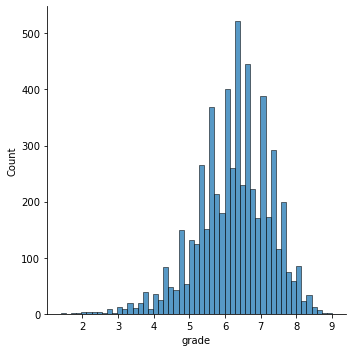

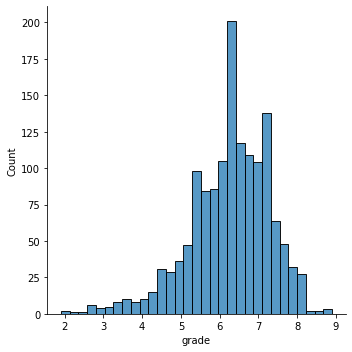

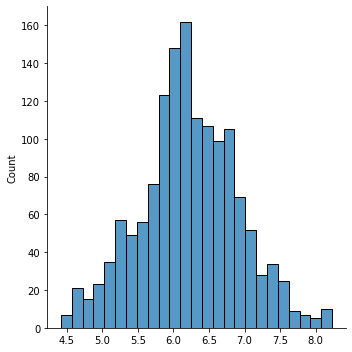

In [33]:
import seaborn as sns
sns.displot(y_train, )
sns.displot(y_test)
sns.displot(pipeline.predict(X_test));

> The main problem is that we have a tail on the train/test distribution, which impacts a lot of our model. Our model perform quite well to predict a grade over 4.5, whereas it can't predict a grade under this treshold. It could explain why our model has a poor R square.